# Установка PySpark

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=07dca00a25174e960e6d20a6ed84a124b0cdadcd94c7e395c1d46c8b50c5c434
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# Импорт необходимых инструментов

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

# Чтение и обработка данных

In [ ]:
spark = SparkSession.builder.appName('MoviesActorsAnalysis').getOrCreate()

actors_df = spark.read.csv('/content/drive/MyDrive/actors.csv', header=True, inferSchema=True)
movies_df = spark.read.csv('/content/drive/MyDrive/movies.csv', header=True, inferSchema=True)
movie_actors_df = spark.read.csv('/content/drive/MyDrive/movie_actors.csv', header=True, inferSchema=True)

df = actors_df.join(movie_actors_df, 'actor_id', 'inner').join(movies_df, 'movie_id', 'inner')

df.show()

+--------+--------+--------+----------+---------+--------+------+------------+-------------+
|movie_id|actor_id|    name|birth_date|  country|   title| genre|release_date|       budget|
+--------+--------+--------+----------+---------+--------+------+------------+-------------+
|       7|       1| Actor_1|1960-12-31|   Canada| Movie_7| Drama|  2006-12-31|4.456703643E7|
|       9|       2| Actor_2|1962-12-31|       UK| Movie_9|Action|  2008-12-31|2.201627853E7|
|      10|       4| Actor_4|1966-12-31|       UK|Movie_10|Action|  2009-12-31|1.244027929E7|
|      15|       5| Actor_5|1968-12-31|    India|Movie_15| Drama|  2014-12-31|9.809858674E7|
|      11|       5| Actor_5|1968-12-31|    India|Movie_11|Comedy|  2010-12-31|8.380567138E7|
|      16|       5| Actor_5|1968-12-31|    India|Movie_16|Comedy|  2015-12-31|6.098669335E7|
|       3|       6| Actor_6|1970-12-31|      USA| Movie_3|Action|  2002-12-31| 1.80157747E7|
|      19|       8| Actor_8|1974-12-31|Australia|Movie_19|Action|  201

# Анализ данных

In [ ]:
df.createOrReplaceTempView('df')

# топ 5 жанров по количеству фильмов
top5_genres = spark.sql('''
    SELECT distinct genre, COUNT(DISTINCT movie_id) AS number_of_movies
    FROM df
    GROUP BY genre
    ORDER BY number_of_movies DESC
    LIMIT 5
''')

top5_genres.show()
top5_genres_data = top5_genres.collect()

# актер с наибольшим количеством фильмов
top_actor = spark.sql('''
    SELECT name, COUNT(DISTINCT movie_id) AS number_of_movies
    FROM df
    GROUP BY name
    ORDER BY number_of_movies DESC
    LIMIT 1
''')

top_actor.show()
top_actor_data = top_actor.collect()

# средний бюджет фильмов по жанрам
genre_budget = spark.sql('''
    SELECT genre, AVG(budget) AS average_budget
    FROM df
    GROUP BY genre
''')

genre_budget.show()
genre_budget_data = genre_budget.collect()

# фильмы, в которых снялось более 1 актера из одной страны
movies_with_multiple_actors_same_country = spark.sql('''
    SELECT title, country, COUNT(actor_id) AS number_of_actors
    FROM df
    GROUP BY title, country
    HAVING COUNT(actor_id) > 1
''')

movies_with_multiple_actors_same_country.show()
movies_with_multiple_actors_same_country_data = movies_with_multiple_actors_same_country.collect()

+------+----------------+
| genre|number_of_movies|
+------+----------------+
|Action|               6|
| Drama|               4|
|Comedy|               4|
|Horror|               2|
|Sci-Fi|               2|
+------+----------------+

+--------+----------------+
|    name|number_of_movies|
+--------+----------------+
|Actor_24|               5|
+--------+----------------+

+------+--------------------+
| genre|      average_budget|
+------+--------------------+
| Drama|6.2562771613076925E7|
|Horror|    8.711155335875E7|
|Comedy| 4.883974718111111E7|
|Action|2.5901128670000006E7|
|Sci-Fi| 7.929615028999999E7|
+------+--------------------+

+--------+---------+----------------+
|   title|  country|number_of_actors|
+--------+---------+----------------+
| Movie_7|    India|               2|
| Movie_3|      USA|               2|
|Movie_10|       UK|               2|
|Movie_15|    India|               2|
|Movie_18|Australia|               2|
| Movie_1|    India|               3|
| Movie_2| 

# Визуализация

<ipython-input-7-5bfa34fad924>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=genres, y=number_of_movies, palette='viridis')


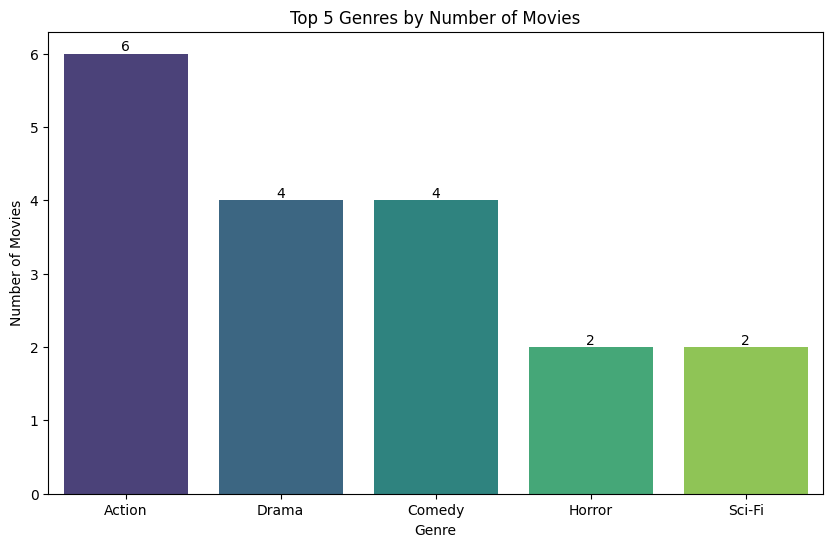

<ipython-input-7-5bfa34fad924>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=genres_budget, y=average_budget, palette='magma')


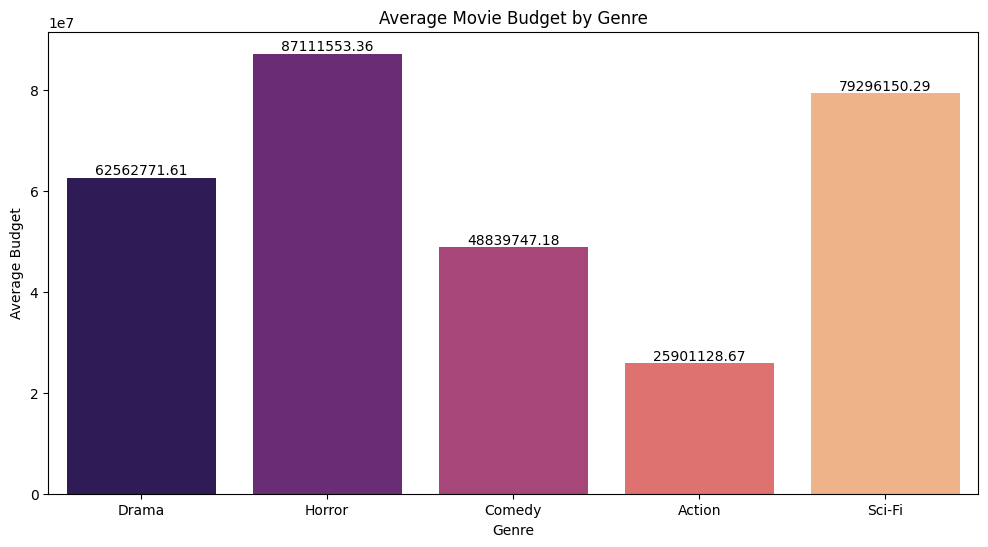

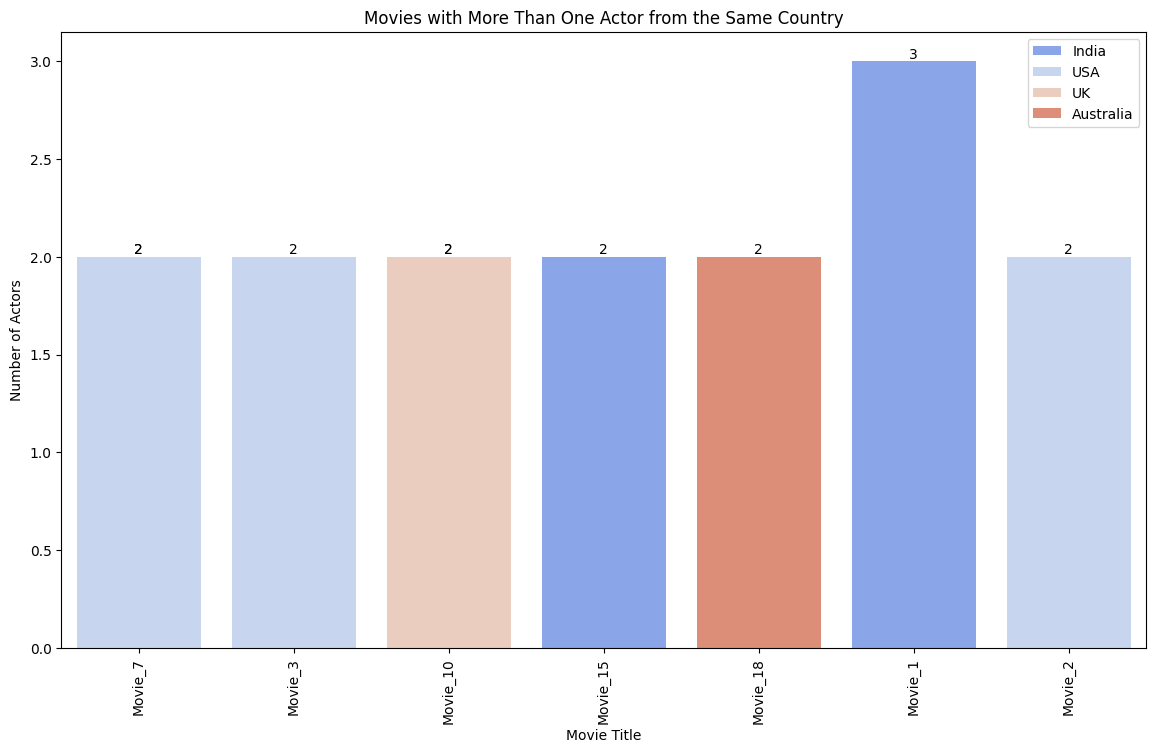

In [ ]:
# топ 5 жанров по количеству фильмов
genres = [row['genre'] for row in top5_genres_data]
number_of_movies = [row['number_of_movies'] for row in top5_genres_data]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=genres, y=number_of_movies, palette='viridis')
plt.title('Top 5 Genres by Number of Movies')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
for i in ax.containers:
    ax.bar_label(i, fmt='%d')
plt.show()

# средний бюджет фильмов по жанрам
genres_budget = [row['genre'] for row in genre_budget_data]
average_budget = [row['average_budget'] for row in genre_budget_data]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=genres_budget, y=average_budget, palette='magma')
plt.title('Average Movie Budget by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Budget')
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
plt.show()

# фильмы с более чем одним актером из одной страны
titles = [row['title'] for row in movies_with_multiple_actors_same_country_data]
number_of_actors = [row['number_of_actors'] for row in movies_with_multiple_actors_same_country_data]
countries = [row['country'] for row in movies_with_multiple_actors_same_country_data]

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=titles, y=number_of_actors, hue=countries, dodge=False, palette='coolwarm')
plt.title('Movies with More Than One Actor from the Same Country')
plt.xlabel('Movie Title')
plt.ylabel('Number of Actors')
for i in ax.containers:
    ax.bar_label(i, fmt='%d')
plt.xticks(rotation=90)
plt.show()